In [55]:
import numpy as np
from scipy.sparse import random
import matplotlib.pyplot as plot

In [56]:
V = 2 # number of features
R = 20 # size of reservoir
LEARN_TIME = 10
READOUT_TIME = 1#50
LEARNING_RATE = 0.01
DENSITY = 0.25
NUM_ITERATIONS = 1000

Wr = random(R, R, density=DENSITY).toarray()
# Win = random(V, R, density=DENSITY).toarray()
Win = np.random.random((V + 1 , R))
W_readout = np.random.random((R + 1, 1))
W_PLA = np.random.random((V + 1, 1))

X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
h = np.random.random((R, 1))
y = np.array([0, 0, 0, 1]) 
delta = []

In [57]:
def advance_state(activation_function, h, x, Win, Wr, delta):
    h_new = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
    h_new = activation_function(h_new)
    delta.append(np.sum(h_new - h))
    return h_new

In [58]:
def relu(x):
    if x > 0:
	    return x
    else:
        return 0
    
def linear(x):
	return x

def sigmoid(x):
	return 1/(1 + np.exp(-x))


def threshold(x, THRESHOLD):
	if x > THRESHOLD:
		return 1
	return 0

In [59]:
def forward(x, Win, Wr, W_readout, h):
	predict = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
	predict = np.vstack(([1], predict))
	return np.matmul(W_readout.transpose(), predict)

def readout_inputs(x, Win, Wr, h): 
	predict = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
	predict = np.vstack(([1], predict))
	return predict

def readout_forward(x, W_readout, Win):
	predict = np.matmul(Win.transpose(), np.vstack(([1], x)))
	predict = np.matmul(W_readout.transpose(), np.vstack(([1], predict)))
	return predict

/u/rkank/anaconda3/envs/ESN_Bianchi/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/u/rkank/anaconda3/envs/ESN_Bianchi/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in square
/u/rkank/anaconda3/envs/ESN_Bianchi/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in multiply
/u/rkank/anaconda3/envs/ESN_Bianchi/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in add


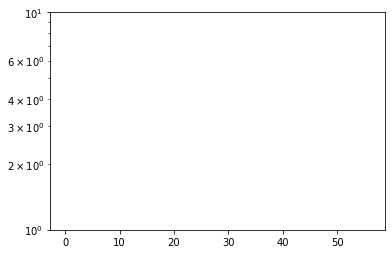

nan 499397665.1162888


In [52]:
losses = []
errors = []

for epoch in range(NUM_ITERATIONS):
	permutation = np.random.permutation(4)

	batch_error = 0

	for datapoint in permutation:
		x = X[:, datapoint].reshape(2, 1)
		x = np.vstack(([1], x))
		label = y[datapoint]

		for iteration in range(LEARN_TIME):
		    h = advance_state(sigmoid, h, x, Win, Wr, delta)

		error = 0
		for iteration in range(READOUT_TIME):
			predict = forward(x, Win, Wr, W_readout, h)
			batch_error += 2 * (predict - label) * readout_inputs(x, Win, Wr, h)
		errors.append(np.square(batch_error).item(0))

		W_readout = W_readout - LEARNING_RATE * batch_error / (READOUT_TIME)

	loss = 0
	for datapoint in range(4):
		x = X[:, datapoint].reshape(2, 1)
		x = np.vstack(([1], x))
		loss += np.square(forward(x, Win, Wr, W_readout, h).item(0) - y[datapoint].item(0))

	losses.append(loss / 4)

plot.plot(losses)
plot.yscale("log")
plot.show()

print(losses[-1], min(losses))

# for datapoint in range(4):
# 	x = X[:, datapoint].reshape(2,1)
# 	x = np.vstack(([1], x))
# 	predict = forward(x, Win, Wr, h)
# 	print(x, predict, threshold(predict, 0.5))

In [53]:
runs = []

def iterate():
	global W_PLA, Win, W_readout
	W_PLA = np.random.random((V + 1, 1))
	losses = []
	
	for epoch in range(NUM_ITERATIONS):
		permutation = np.random.permutation(X.shape[1])
		
		batch_error = 0
		for datapoint in permutation:
			x = X[:, datapoint].reshape(2, 1)
			label = y[datapoint]
			
			predict = readout_forward(x, W_readout, Win)
			batch_error += 2 * (predict - label) * np.vstack(([1], np.matmul(Win.transpose(), np.vstack(([1], x)))))
			
		W_readout = W_readout - LEARNING_RATE * batch_error / permutation.size
		
		loss = 0
		for datapoint in range(permutation.size):
			x = X[:, datapoint].reshape(2, 1)
			loss += np.square(readout_forward(x, W_readout, Win).item(0) - y[datapoint].item(0))
	
		if (losses.__len__() > 0) and (loss/permutation.size > losses[-1]):
			losses.append(loss / permutation.size)
			break
		
		losses.append(loss / permutation.size)
		
	plot.plot(losses)
	plot.yscale("log")
	plot.show()

	print(losses[-1], min(losses))
	
	error_count = 0
	for datapoint in range(4):
		x = X[:, datapoint].reshape(2,1)
		predict = readout_forward(x, W_readout, Win)
		print(x, predict, threshold(predict, 0.5))
		if threshold(predict, 0.5) != (x[0].item() and x[1].item()):
			error_count += 1
			
	# runs.append((error_count, Win, W_readout))
	# 
	# plot_x = np.linspace(-0.25, 1.25, 100)
	# plot_y = (0.5 - W_PLA[0] - W_PLA[1] * plot_x) / W_PLA[2]
	# 
	# plot.plot(plot_x, plot_y)
	# plot.xlim(-0.25, 1.25)
	# plot.ylim(-0.25, 1.25)
	# plot.scatter((0, 0, 1, 1), (0, 1, 0, 1), color='red')
	# plot.annotate((0,0), (0,0))
	# plot.annotate((0,1), (0,1))
	# plot.annotate((1,0), (1,0))
	# plot.annotate((1,1), (1,1))

In [54]:
# iterate()

